# Approach 2: Segmented Gaussian Process

(Description here)

In [2]:
# Imports

import gpytorch
import plotly.graph_objects as go
import torch
from IPython.display import Image
from plotly import subplots
from sklearn.cluster import KMeans

import utils

image_type = "static"  # html / static

In [3]:
# Load input data

filename_identifier = "B"

# Target data files
filename_true = f"data/true_data_{filename_identifier}.csv"
filename_obs = f"data/observed_data_{filename_identifier}.csv"

# Load as tensors
true_x, true_y, obs_x, obs_y = utils.load_true_and_obs_tensors(
    filename_true,
    filename_obs,
)

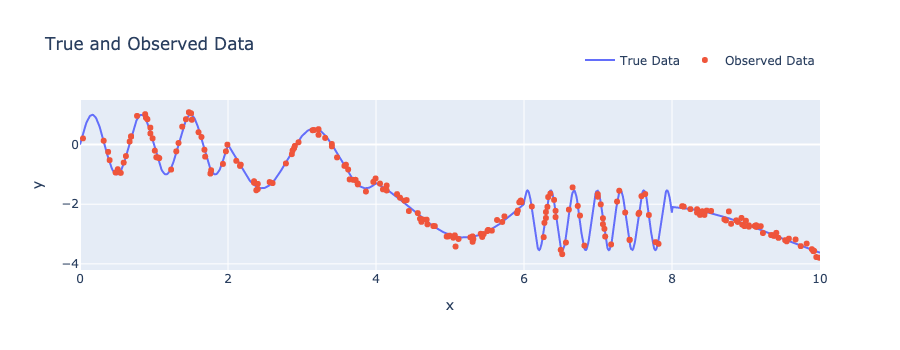

In [4]:
# Plot the data

fig = go.Figure()

# Plot true function and sampled noisy data
fig.add_trace(go.Scatter(x=true_x, y=true_y, mode="lines", name="True Data"))
fig.add_trace(go.Scatter(x=obs_x, y=obs_y, mode="markers", name="Observed Data"))

# Update layout
fig.update_xaxes(range=[0, 10])
fig.update_layout(title="True and Observed Data", xaxis_title="x", yaxis_title="y")
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.15, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=900, height=350)))

## Method: Segmented Gaussian Process Models

In [5]:
# Define the model, likelihood, and additional model components


def partition_data(train_x, train_y, num_partitions):
    """Partition the data into num_partitions clusters using KMeans."""
    kmeans = KMeans(n_clusters=num_partitions, n_init=10)
    labels = kmeans.fit_predict(train_x.numpy())
    partitions = []
    for i in range(num_partitions):
        mask = labels == i
        partitions.append((train_x[mask], train_y[mask]))
    return partitions, kmeans, labels


class ExactGPModel(gpytorch.models.ExactGP):
    """Standard Exact GP model with RBF kernel."""

    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class SegmentedGP:
    """Segmented Gaussian Process model that divides the input space into clusters
    and fits a separate GP for each cluster.
    """

    def __init__(self, train_x, train_y, num_clusters=5, likelihood=None):
        self.train_x = train_x.view(-1, 1)
        self.train_y = train_y.view(-1)
        self.num_clusters = num_clusters

        # Perform clustering on the input data
        self.partitions, self.kmeans, self.labels = partition_data(
            self.train_x, self.train_y, num_clusters
        )

        # Create a separate GP model for each cluster
        self.models = []
        self.likelihoods = []

        for x_part, y_part in self.partitions:
            # Get data for this cluster
            # Only create a model if there are points in this cluster
            if len(x_part) > 0:
                if likelihood is None:
                    cluster_likelihood = gpytorch.likelihoods.GaussianLikelihood()
                else:
                    cluster_likelihood = likelihood

                cluster_model = ExactGPModel(x_part, y_part, cluster_likelihood)

                self.models.append(cluster_model)
                self.likelihoods.append(cluster_likelihood)
            else:
                # If no points in cluster, add None placeholders
                self.models.append(None)
                self.likelihoods.append(None)

    def train(self, num_iterations=100, lr=0.1):
        # Train each model separately
        for model, likelihood in zip(self.models, self.likelihoods):
            if model is not None:
                # Set models in training mode
                model.train()
                likelihood.train()
                model.covar_module.base_kernel.lengthscale = 0.01

                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Define loss function (negative log likelihood)
                mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

                # Training loop
                for j in range(num_iterations):
                    optimizer.zero_grad()
                    output = model(model.train_inputs[0])
                    loss = -mll(output, model.train_targets)
                    loss.backward()
                    optimizer.step()
                    if j % 10 == 0:
                        print(f"Iter {j}: Loss = {loss.item():.3f}")

                # Set models to evaluation mode after training
                model.eval()
                likelihood.eval()

    def predict(self, test_x, num_posterior_samples=10):
        # Determine which cluster each test point belongs to
        test_labels = self.kmeans.predict(test_x.numpy().reshape(-1, 1))

        # Initialize output tensors
        mean = torch.zeros(test_x.size(0))
        variance = torch.zeros(test_x.size(0))

        # Make predictions for each point using the appropriate cluster model
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            for i, (model, likelihood) in enumerate(zip(self.models, self.likelihoods)):
                if model is not None:
                    # Get points belonging to this cluster
                    cluster_mask = test_labels == i
                    if cluster_mask.sum() > 0:
                        cluster_test_x = test_x[cluster_mask]

                        # Make predictions
                        predictions = likelihood(model(cluster_test_x))

                        # Store results
                        mean[cluster_mask] = predictions.mean
                        variance[cluster_mask] = predictions.variance

        # Posterior samples
        samples = torch.zeros(test_x.size(0), num_posterior_samples)
        with torch.no_grad():
            for i, (model, likelihood) in enumerate(zip(self.models, self.likelihoods)):
                if model is not None:
                    cluster_mask = test_labels == i
                    if cluster_mask.sum() > 0:
                        cluster_test_x = test_x[cluster_mask]

                        # Get posterior distribution
                        posterior = likelihood(model(cluster_test_x))

                        # Sample from posterior
                        cluster_samples = posterior.sample(
                            torch.Size([num_posterior_samples])
                        ).t()

                        # Store samples
                        samples[cluster_mask] = cluster_samples

        # Calculate confidence intervals
        lower = mean - 1.96 * torch.sqrt(variance)
        upper = mean + 1.96 * torch.sqrt(variance)

        return test_labels, mean, lower, upper, samples


In [6]:
# Initialize likelihood and model
train_x, train_y = obs_x, obs_y
num_clusters = 15
model = SegmentedGP(train_x, train_y, num_clusters=num_clusters)

In [7]:
# Train the model

n_epochs = 200
model.train(num_iterations=n_epochs)


Iter 0: Loss = 4.800
Iter 10: Loss = 2.139
Iter 20: Loss = 1.582
Iter 30: Loss = 1.369
Iter 40: Loss = 1.173
Iter 50: Loss = 0.917
Iter 60: Loss = 0.574
Iter 70: Loss = 0.159
Iter 80: Loss = -0.260
Iter 90: Loss = -0.569
Iter 100: Loss = -0.668
Iter 110: Loss = -0.662
Iter 120: Loss = -0.680
Iter 130: Loss = -0.688
Iter 140: Loss = -0.692
Iter 150: Loss = -0.697
Iter 160: Loss = -0.700
Iter 170: Loss = -0.703
Iter 180: Loss = -0.705
Iter 190: Loss = -0.706
Iter 0: Loss = 1.212
Iter 10: Loss = 0.889
Iter 20: Loss = 0.524
Iter 30: Loss = 0.207
Iter 40: Loss = 0.003
Iter 50: Loss = -0.036
Iter 60: Loss = -0.036
Iter 70: Loss = -0.044
Iter 80: Loss = -0.044
Iter 90: Loss = -0.044
Iter 100: Loss = -0.044
Iter 110: Loss = -0.044
Iter 120: Loss = -0.045
Iter 130: Loss = -0.045
Iter 140: Loss = -0.045
Iter 150: Loss = -0.045
Iter 160: Loss = -0.045
Iter 170: Loss = -0.045
Iter 180: Loss = -0.045
Iter 190: Loss = -0.045
Iter 0: Loss = 3.903
Iter 10: Loss = 1.856
Iter 20: Loss = 1.437
Iter 30: L

In [9]:
# Evaluate the model

num_posterior_samples = 12

labels, mean, upper, lower, samples = model.predict(
    true_x,
    num_posterior_samples=num_posterior_samples,
)

## Plotting

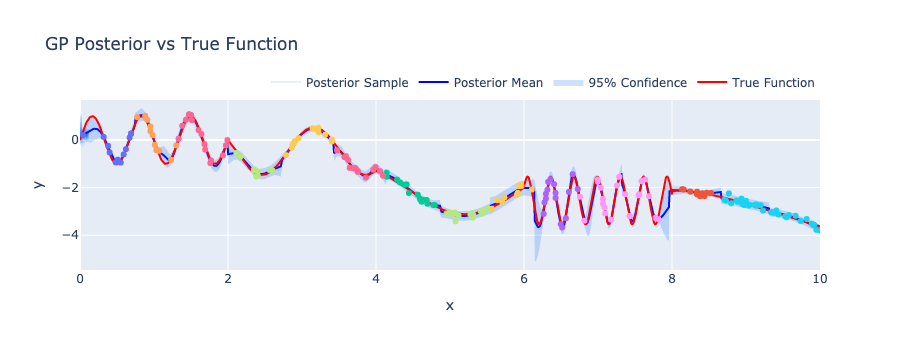

In [10]:
# Plot the predictions

fig = go.Figure()

# Plot posterior samples
for i in range(num_posterior_samples):
    fig.add_trace(
        go.Scatter(
            x=true_x,
            y=samples[i, :],
            mode="lines",
            line=dict(color="rgba(0,100,255,0.1)"),
            name="Posterior Sample",
            legendgroup="posterior_sample",
            showlegend=(i == 0),
        )
    )

# Plot mean prediction
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=mean,
        mode="lines",
        line=dict(color="blue"),
        name="Posterior Mean",
    )
)

# Plot confidence bounds
fig.add_trace(
    go.Scatter(
        x=torch.cat([true_x, true_x.flip(0)]),
        y=torch.cat([upper, lower.flip(0)]),
        fill="toself",
        fillcolor="rgba(0,100,255,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="95% Confidence",
    )
)

# Plot true function
fig.add_trace(
    go.Scatter(
        x=true_x, y=true_y, mode="lines", line=dict(color="red"), name="True Function"
    )
)

# Plot training data
for part_x, part_y in model.partitions:
    fig.add_trace(
        go.Scatter(
            x=part_x.view(-1),
            y=part_y.view(-1),
            mode="markers",
            name="Training Data",
            legendgroup="training_data",
            showlegend=(i == 0),
        )
    )

# Update layout
fig.update_xaxes(range=[0, 10])
fig.update_layout(
    title="GP Posterior vs True Function", xaxis_title="x", yaxis_title="y"
)
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=900, height=350)))

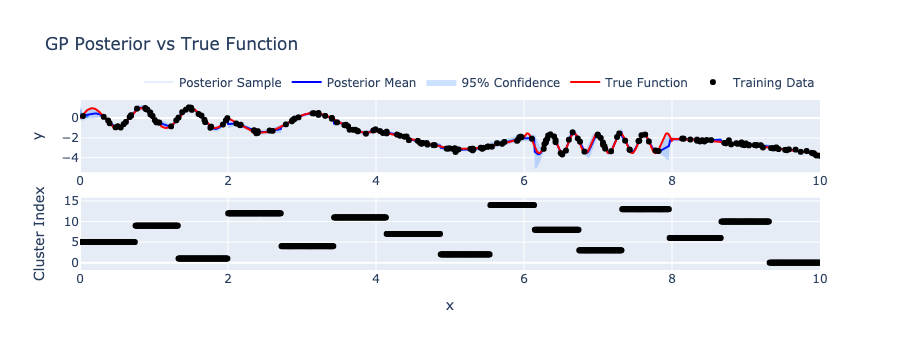

In [11]:
# Plot the posterior results and the warped results
fig = subplots.make_subplots(rows=2, cols=1)

# Plot posterior samples
for i in range(num_posterior_samples):
    fig.add_trace(
        go.Scatter(
            x=true_x,
            y=samples[i],
            mode="lines",
            line=dict(color="rgba(0,100,255,0.1)"),
            name="Posterior Sample",
            legendgroup="posterior_sample",
            showlegend=(i == 0),
        ),
        row=1,
        col=1,
    )

# Plot mean prediction
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=mean,
        mode="lines",
        line=dict(color="blue"),
        name="Posterior Mean",
        legendgroup="posterior_mean",
    ),
    row=1,
    col=1,
)

# Plot confidence bounds
fig.add_trace(
    go.Scatter(
        x=torch.cat([true_x, true_x.flip(0)]),
        y=torch.cat([upper, lower.flip(0)]),
        fill="toself",
        fillcolor="rgba(0,100,255,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="95% Confidence",
        legendgroup="confidence_bounds",
    ),
    row=1,
    col=1,
)

# Plot true function
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=true_y,
        mode="lines",
        line=dict(color="red"),
        name="True Function",
        legendgroup="true_function",
    ),
    row=1,
    col=1,
)

# Plot training data
fig.add_trace(
    go.Scatter(
        x=train_x.view(-1),
        y=train_y.view(-1),
        mode="markers",
        marker=dict(color="black"),
        name="Training Data",
        legendgroup="training_data",
    ),
    row=1,
    col=1,
)

# Plot labels
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=labels,
        mode="markers",
        marker=dict(color="black"),
        name="Labels",
        legendgroup="labels",
        showlegend=False,
    ),
    row=2,
    col=1,
)

# Update layout
fig.update_xaxes(range=[0, 10], row=1, col=1)
fig.update_xaxes(range=[0, 10], row=2, col=1)
fig.update_layout(title="GP Posterior vs True Function")
fig.update_xaxes(title_text="x", row=2, col=1)
fig.update_yaxes(title_text="y", row=1, col=1)
fig.update_yaxes(title_text="Cluster Index", row=2, col=1)
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=900, height=350)))